### This Notebook is based by enlarge on Alexander Scarlet's [ResNet50 Feat Extract](https://www.kaggle.com/drscarlat/melanoma-resnet50-feat-extract) Notebook.  I changed a few parameters to optimize it such that it takes up less memory and works faster to classify new images.
***

### The parameters that have been altered are:

1. In the 1st: model.add(layers.Dropout( **changed rate from 0.5 to 0.4**))
2. In model.add(layers.Dense(**changed 1024 to 562**, activation='relu',kernel_regularizer=regularizers.l2(**and changed 0.001 to 0.003**))) 
3. In the 2nd: model.add(layers.Dropout(**changed rate from 0.5 to 0.3**))
4. Changed the batch size from 20 to 64

### As a result, the number of parameters dropped from 126,351,234 down to 79,987,224.
***
### Acknowledgments:
Alexander Scarlet for his 2 notebooks:<br />
a. Melanoma - [ResNet50 Feat Extract](https://www.kaggle.com/drscarlat/melanoma-resnet50-feat-extract)<br />
b. Melanoma - [ResNet50 Fine Tune](https://www.kaggle.com/drscarlat/melanoma-resnet50-fine-tune)

Gabriel Vasconcelos for his notebook:<br />
a. Melanoma - [Classifier Mobilenet](https://www.kaggle.com/gabrielmv/melanoma-classifier-mobilenet)

Daniel Kim for his notebook:<br />
a. [Technical Report: Pneumonia Detection Image Classification](https://github.com/dansthemanwhosakid/CNN-Classification-X-rays) for his Confusion Matrix
***
Data Source:
The dermatoscopic images in this data set originate from [HAM10k](https://www.nature.com/articles/sdata2018161).<br /> In their study, they classify the images into 7 diagnoses.<br />
1. Actinic Keratoses
2. Basal cell carcinoma
3. Benign keratosis
4. Dermatofibroma
5. Melanocytic nevi
6. Melanoma
7. Vascular Skin Lesions
***
### The images were then arranged for the kaggle dataset based on class as either Melanoma or Not Melanoma.
***

## Import Packages

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
import os
from os.path import join

import tensorflow as tf
from keras.applications.resnet import ResNet50
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

from tensorflow.python.compiler.tensorrt import trt_convert as trt

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import image
# from keras.applications import ResNet50

print(tf.version.VERSION)
print(os.listdir("../input"))

2.1.0
['melanoma']


In [14]:
!pip install -q pyyaml h5py

In [28]:
PATH = "../input/melanoma/DermMel/"
print(os.listdir(PATH))

['valid', 'train_sep', 'test']


In [29]:
PATHtrain = PATH + 'train_sep'
PATHtest = PATH + 'test/'
PATHvalid = PATH + 'valid/'

## Instantiate Convoluted Base Model - ResNet50



In [30]:
conv_base = ResNet50(weights='imagenet',
include_top=False,
input_shape=(224, 224, 3))

print(conv_base.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Create Model Layers

In [31]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(rate = 0.4))
model.add(layers.Dense(562, activation='relu',kernel_regularizer=regularizers.l2(0.003)))
model.add(layers.Dropout(rate = 0.3))
model.add(layers.Dense(2, activation='sigmoid'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 562)               56398386  
_________________________________________________________________
dropout_4 (Dropout)          (None, 562)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1126      
Total params: 79,987,224
Trainable params: 79,934,104
Non-trainable params: 53,120
_____________________________________

## Make the conv_base NOT Trainable:

In [32]:
for layer in conv_base.layers[:]:
   layer.trainable = False

print('conv_base is now NOT trainable')

conv_base is now NOT trainable


## Compile Model

In [33]:
model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("model compiled")
print(model.summary())

model compiled
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 562)               56398386  
_________________________________________________________________
dropout_4 (Dropout)          (None, 562)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1126      
Total params: 79,987,224
Trainable params: 56,399,512
Non-trainable params: 23,587,712
__________________

## Prep the Train, Valid, and Test directories for the Generator

In [34]:
train_dir = PATHtrain
validation_dir = PATHvalid
test_dir = PATHtest
batch_size = 64
target_size=(224, 224)

#train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,target_size=target_size,batch_size=batch_size)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,target_size=target_size,batch_size=batch_size)
test_generator = test_datagen.flow_from_directory(
    test_dir,target_size=target_size,batch_size=batch_size)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


## Print Class Indices

In [35]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'Melanoma': 0, 'NotMelanoma': 1}
{'Melanoma': 0, 'NotMelanoma': 1}
{'Melanoma': 0, 'NotMelanoma': 1}


## Fit and Generate the Model

In [36]:
# Short training ONLY my top layers 
#... so the conv_base weights will not be destroyed by the random intialization of the new weights


history = model.fit_generator(train_generator,
                              epochs=20,
                              steps_per_epoch = 10682 // batch_size,
                              validation_data = validation_generator,
                              validation_steps = 3562 // batch_size)

Epoch 1/20
166/166 [==============================] - 227s 1s/step - loss: 3.1493 - accuracy: 0.8970 - val_loss: 8.4883 - val_accuracy: 0.4997
Epoch 2/20
166/166 [==============================] - 224s 1s/step - loss: 2.2325 - accuracy: 0.9260 - val_loss: 14.1016 - val_accuracy: 0.5003
Epoch 3/20
166/166 [==============================] - 225s 1s/step - loss: 1.7004 - accuracy: 0.9306 - val_loss: 10.3074 - val_accuracy: 0.5076
Epoch 4/20
166/166 [==============================] - 224s 1s/step - loss: 1.3276 - accuracy: 0.9333 - val_loss: 4.9611 - val_accuracy: 0.5200
Epoch 5/20
166/166 [==============================] - 222s 1s/step - loss: 1.0702 - accuracy: 0.9334 - val_loss: 1.5041 - val_accuracy: 0.6891
Epoch 6/20
166/166 [==============================] - 219s 1s/step - loss: 0.8768 - accuracy: 0.9388 - val_loss: 1.0029 - val_accuracy: 0.9172
Epoch 7/20
166/166 [==============================] - 220s 1s/step - loss: 0.7444 - accuracy: 0.9385 - val_loss: 0.7494 - val_accuracy: 0.94

# Plot accuracy and validation loss

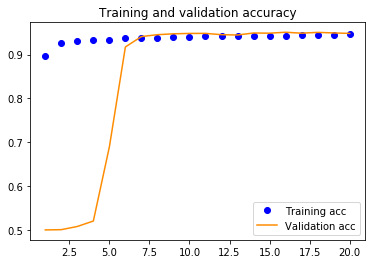

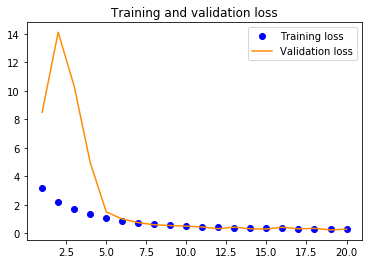

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'darkorange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Confusion Matrix
### I attempted to create a confusion matrix based on one that was built by Daniel Kim in his notebook [Technical Report: Pneumonia Detection Image Classification](https://github.com/dansthemanwhosakid/CNN-Classification-X-rays) to use as a useful tool to understand how well my model performed. Unfortunately with the usage of fit_generator, my confusion matrix outputed results that are far from what is expected.  I am leaving it in the notebook to demonstrate the attempt, but kindly ignore the results.

In [40]:
val_batch_size = 64

In [41]:
validation_accuracy = model.evaluate_generator(validation_generator, steps = 3562 // val_batch_size)

In [42]:
validation_accuracy[1]

0.9487215876579285

In [44]:
y_true = validation_generator.classes

In [45]:
y_proba = model.predict_generator(validation_generator)

In [46]:
y_preds = [1 if proba > 0.5 else 0 for proba in y_proba[:,0]]

In [48]:
cm_def = np.array([['True Positive', 'False Negative'],
                ['False Positive', 'True Negative']])
cm_def = pd.DataFrame(cm_def,columns = ['pred pos', 'pred neg'], index = ['actual pos','actual neg'])


cm = confusion_matrix(y_true, y_preds)
cm_df = pd.DataFrame(cm, columns = ['pred pos', 'pred neg'], index = ['actual pos','actual neg'])

from IPython.display import display
display(cm_def)
display(cm_df)

,pred pos,pred neg
actual pos,True Positive,False Negative
actual neg,False Positive,True Negative


,pred pos,pred neg
actual pos,904,877
actual neg,918,863


In [49]:
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)

In [50]:
print(f'Precision: {round(precision*100,2)}%')
print(f'Recall: {round(recall*100, 2)}%')

Precision: 49.6%
Recall: 48.46%


## Save my model in .h5 and json formats

In [51]:
model.save(filepath = './model_final_res50.h5')

In [52]:
def save_model(model, file_path):
    model_json = model.to_json()
    with open('model.json', 'w') as json_file:
        json_file.write(model_json)

In [ ]:
save_model(model, os.listdir("../input"))

## Load Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
CNN = load_model('model_final_res50.h5')

In [ ]:
CNN.summary()

In [ ]:
CNN.predict_proba( )